# Example: Evolutive equilibrium calculations

This notebook will demonstrate the core use-case for FreeGSNKE: simulating the (time-dependent) evolution of Grad-Shafranov (GS) equilibria. In particular we will simulate a **vertical displacement event (VDE)**.

To do this, we need to:
- build the tokamak machine.
- instatiate a GS equilibrium (to be used as an initial condition for the evolutive solver).
- calculate a vertical instability growth rate for this equilibrium and carry out passive structure mode removal via a normal mode decomposition (i.e. removing modes that have little effect on the evolution). 
- define time-dependent plasma current density profile parameters and coil voltages.
- evolve the active coil currents, the total plasma current, and the equilbirium using these profile parameters and voltages by solving the circuit equations alongside the GS equation.

Refer to the paper by [Amorisco et al. (2024)](https://pubs.aip.org/aip/pop/article/31/4/042517/3286904/FreeGSNKE-A-Python-based-dynamic-free-boundary) for more details. 

We should note that here we will use **fixed** (time-independent) profile parameters and voltages to simulate a VDE, however, truly time-dependent parameters would be required to simulate a plasma shot (see future notebooks). 


## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import pickle

## Build the machine

In [2]:
# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"../machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.


## Diverted plasma example

### Instantiate an equilibrium

In [ ]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

### Instatiate a profile object

In [ ]:
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8.1e3,  # profile object
    Ip=6.2e5,     # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Set coil currents
Here we set coil currents that create a diverted plasma (as seen in prior notebooks). 

In [5]:
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak.set_coil_current(coil_label=key, current_value=current_values[key])

### Instatiate the solver


In [5]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Call forward solver to find equilibrium 

In [7]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-8,
                     verbose=0
                     )

Forward static solve SUCCESS. Tolerance 5.70e-09 (vs. requested 1.00e-08) reached in 24/100 iterations.


### Plot the initial equilibrium 

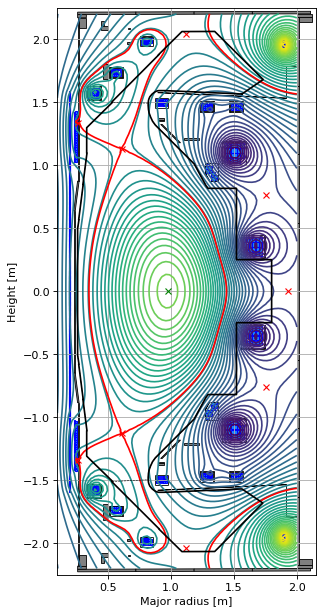

In [8]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

### Time evolution

We are now ready to solve the forward time-evolutive problem.

#### Initialise nonlinear (evolutive) solver
To start, we need to initialise the evolutive solver object, `freegsnke.nonlinear_solve.nl_solver`.

The time-evolutive solver requires:
- `eq`: an equilibrium to inform the solver of the machine and domain properties.
- `profiles`: defined above.
- `full_timestep`: the time step by which time is advanced at every call of the stepper (this can be modified later depending on the growth rate of the equilibrium). An appropriate time step can also be set based on the growth rate calculation. Use `automatic_timestep` to set the time step in units of the (inverse of the) growth rate.
- `plasma_resistivity`: resistivity of the plasma (which here is assumed to be constant during the time evolution but can be made time-dependent if known).
- `min_dIy_dI`: threshold value below which passive structure normal modes are dropped. Modes with norm(d(Iy)/dI)<`min_dIy_dI` are dropped, which filters out modes that do not actually couple with the plasma.
- `max_mode_frequency`: threshold value for characteristic frequencies above which passive structure normal modes are dropped (i.e. the fast modes).

Other customisable inputs are available, do see the documentation for more details. For example, one may explicitly set your own resistance and inductance matries for the tokamak machine. 

The solver can be used on different equilibria and/or profiles, but these need to have the same machine, domain, and limiter as the one used at the time of the solver instantiation. For different machines, a new time-evolutive solver should be created.

The input equilibrium and profile functions are also used as the expansion point around which the dynamics are linearised.

In [9]:
from freegsnke import nonlinear_solve

stepping = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    GSStaticSolver=GSStaticSolver,
    full_timestep=5e-4, 
    plasma_resistivity=1e-6,
    max_mode_frequency=10**2.5,
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 5.70e-09 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'threshold_dIy_dI', 'min_dIy_dI', and 'max_mode_frequency' option selected --> passive structure modes are selected according to these thresholds.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      16 selected with characteristic timescales larger than 'max_mode_frequency'
      23 selected that couple with the plasma more than 'threshold_dIy_dI', despite having fast timescales
      4 selected that couple with the plasma less than 'min_dIy_dI', despite having slow timescales
      total selected = 35 (out of 138)
   Total number of modes = 47 (12 active coils + 35 passive structures)
      (Note: some additional modes may be removed after Jacobian 

#### Set active coil voltages

In this example, we will evolve a plasma in absence of any control policy or current drive.

Just as an example, the following calculates active voltages to be applied to the poloidal field coils (and Solenoid) using $V = RI$, with current values as defined by the initial equilibrium (i.e. we have constant voltages).

In most FreeGSNKE use cases, these active voltages will be determined by a control policy.

In [10]:
voltages = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils] 

To start, the solver is prepared by setting the initial conditions.

In [11]:
stepping.initialize_from_ICs(eq, profiles)

#### Set time steps and storage lists
Now we set the total number of time steps we want to simulate and initialise some variables for logging the evolution.

In [12]:
# number of time steps to simulate
max_count = 50

# initialising some variables for iteration and logging
counter = 0
t = 0

history_times = [t]
history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
history_o_points = [stepping.eq1.opt[0]]
history_elongation = [stepping.eq1.geometricElongation()]
history_triangularity = [stepping.eq1.triangularity()]
history_squareness = [stepping.eq1.squareness()[1]]
history_area = [stepping.eq1.separatrix_area()]
history_length = [stepping.eq1.separatrix_length()]



#### Call the solver (linear)
Finally, we call the time-evolutive solver with `stepping.nlstepper()` sequentially until we reach the preset end time.

The following demonstrates a solely linear evolution of the plasma by setting `linear_only=True`.

In [13]:
# loop over time steps
while counter<max_count:
    print(f'Step: {counter}/{max_count-1}')
    print(f'--- t = {t:.2e}')

    # carry out the time step
    stepping.nlstepper(
        active_voltage_vec=voltages, 
        linear_only=True,
    )

    # store information on the time step
    t += stepping.dt_step
    history_times.append(t)
    counter += 1

    # store time-advanced equilibrium, currents, and profiles (+ other quantites of interest)
    history_currents.append(stepping.currents_vec)
    history_equilibria.append(deepcopy(stepping.eq1))
    history_o_points.append(stepping.eq1.opt[0])
    history_elongation.append(stepping.eq1.geometricElongation())
    history_triangularity.append(stepping.eq1.triangularity())
    history_squareness.append(stepping.eq1.squareness()[1])
    history_area.append(stepping.eq1.separatrix_area())
    history_length.append(stepping.eq1.separatrix_length())

# transform lists to arrays
history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)
history_elongation = np.array(history_elongation)
history_triangularity = np.array(history_triangularity)
history_squareness = np.array(history_squareness)
history_area = np.array(history_area)
history_length = np.array(history_length)


Step: 0/49
--- t = 0.00e+00
Step: 1/49
--- t = 5.00e-04
Step: 2/49
--- t = 1.00e-03
Step: 3/49
--- t = 1.50e-03
Step: 4/49
--- t = 2.00e-03
Step: 5/49
--- t = 2.50e-03
Step: 6/49
--- t = 3.00e-03
Step: 7/49
--- t = 3.50e-03
Step: 8/49
--- t = 4.00e-03
Step: 9/49
--- t = 4.50e-03
Step: 10/49
--- t = 5.00e-03
Step: 11/49
--- t = 5.50e-03
Step: 12/49
--- t = 6.00e-03
Step: 13/49
--- t = 6.50e-03
Step: 14/49
--- t = 7.00e-03
Step: 15/49
--- t = 7.50e-03
Step: 16/49
--- t = 8.00e-03
Step: 17/49
--- t = 8.50e-03
Step: 18/49
--- t = 9.00e-03
Step: 19/49
--- t = 9.50e-03


/Users/zn8047/Documents/freegs4e/freegs4e/critical.py:1046: UserWarning: Theta grid too close to X-point, shifting by half-step
  warnings.warn("Theta grid too close to X-point, shifting by half-step")


Step: 20/49
--- t = 1.00e-02
Step: 21/49
--- t = 1.05e-02
Step: 22/49
--- t = 1.10e-02
Step: 23/49
--- t = 1.15e-02
Step: 24/49
--- t = 1.20e-02
Step: 25/49
--- t = 1.25e-02
Step: 26/49
--- t = 1.30e-02
Step: 27/49
--- t = 1.35e-02
Step: 28/49
--- t = 1.40e-02
Step: 29/49
--- t = 1.45e-02
Step: 30/49
--- t = 1.50e-02
Step: 31/49
--- t = 1.55e-02
Step: 32/49
--- t = 1.60e-02
Step: 33/49
--- t = 1.65e-02
Step: 34/49
--- t = 1.70e-02
Step: 35/49
--- t = 1.75e-02
Step: 36/49
--- t = 1.80e-02
Step: 37/49
--- t = 1.85e-02
Step: 38/49
--- t = 1.90e-02
Step: 39/49
--- t = 1.95e-02
Step: 40/49
--- t = 2.00e-02
Step: 41/49
--- t = 2.05e-02
Step: 42/49
--- t = 2.10e-02
Step: 43/49
--- t = 2.15e-02
Step: 44/49
--- t = 2.20e-02
Step: 45/49
--- t = 2.25e-02
Step: 46/49
--- t = 2.30e-02
Step: 47/49
--- t = 2.35e-02
Step: 48/49
--- t = 2.40e-02
Step: 49/49
--- t = 2.45e-02


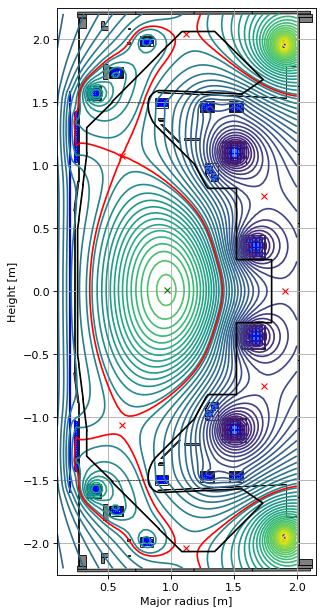

In [14]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)

ax1.grid(True, which='both')
history_equilibria[-1].plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

plt.tight_layout()

#### Call the solver (nonlinear)

Now we evolve the same plasma according to the full nonlinear dynamics for the same time interval. This is done by using `linear_only=False` in the call to the stepper.

We need to re-initialise from the initial conditions and reset the counter, but otherwise the method is identical to the one above.

Note that the full nonlinear evolutive solve is a lot more computationally expensive than solving the linear evolutive problem. As such, the following cell may take several minutes to execute, depending on your hardware.

In [15]:
# reset the solver object by resetting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# initialising some variables for iteration and logging
counter = 0
t = 0

history_times_nl = [t]
history_currents_nl = [stepping.currents_vec]
history_equilibria_nl = [deepcopy(stepping.eq1)]
history_o_points_nl = [stepping.eq1.opt[0]]
history_elongation_nl = [stepping.eq1.geometricElongation()]
history_triangularity_nl = [stepping.eq1.triangularity()]
history_squareness_nl = [stepping.eq1.squareness()[1]]
history_area_nl = [stepping.eq1.separatrix_area()]
history_length_nl = [stepping.eq1.separatrix_length()]

# loop over the time steps
while counter<max_count:

    print(f'Step: {counter}/{max_count-1}')
    print(f'--- t = {t:.2e}')
    
    # carry out the time step
    stepping.nlstepper(
        active_voltage_vec=voltages, 
        linear_only=False,
        verbose=False,
        max_solving_iterations=50,
    )

    # store information on the time step
    t += stepping.dt_step
    history_times_nl.append(t)
    counter += 1
    
    # store time-advanced equilibrium, currents, and profiles (+ other quantites of interest)
    history_currents_nl.append(stepping.currents_vec)
    history_equilibria_nl.append(deepcopy(stepping.eq1))
    history_o_points_nl.append(stepping.eq1.opt[0])
    history_elongation_nl.append(stepping.eq1.geometricElongation())
    history_triangularity_nl.append(stepping.eq1.triangularity())
    history_squareness_nl.append(stepping.eq1.squareness()[1])
    history_area_nl.append(stepping.eq1.separatrix_area())
    history_length_nl.append(stepping.eq1.separatrix_length())

# transform lists to arrays
history_currents_nl = np.array(history_currents_nl)
history_times_nl = np.array(history_times_nl)
history_o_points_nl = np.array(history_o_points_nl)
history_elongation_nl = np.array(history_elongation_nl)
history_triangularity_nl = np.array(history_triangularity_nl)
history_squareness_nl = np.array(history_squareness_nl)
history_area_nl = np.array(history_area_nl)
history_length_nl = np.array(history_length_nl)



Step: 0/49
--- t = 0.00e+00
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 2.15e-03 (vs. requested 5.00e-03).
   Last max. relative flux change: 2.21e-03 (vs. requested 3.00e-03).
   Iterations taken: 3/50.
Step: 1/49
--- t = 5.00e-04
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 1.75e-03 (vs. requested 5.00e-03).
   Last max. relative flux change: 2.89e-03 (vs. requested 3.00e-03).
   Iterations taken: 3/50.
Step: 2/49
--- t = 1.00e-03
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 2.27e-03 (vs. requested 5.00e-03).
   Last max. relative flux change: 2.29e-03 (vs. requested 3.00e-03).
   Iterations taken: 3/50.
Step: 3/49
--- t = 1.50e-03
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 3.32e-03 (vs. requested 5.00e-03).
   Last max. relative flux change: 2.40e-03 (vs. requested 3.00e-03).
   Iterations taken: 3/50.
Step: 4/49
--- t = 2.00e-03
Forward evolutive solve SUCCESS.
   Last max

#### Plot some time-evolving quantities
The following plots the evolution of a number of tracked values and compares the linear/nonlinear evoltuions against one another. 

Text(0, 0.5, 'LCFS circumference')

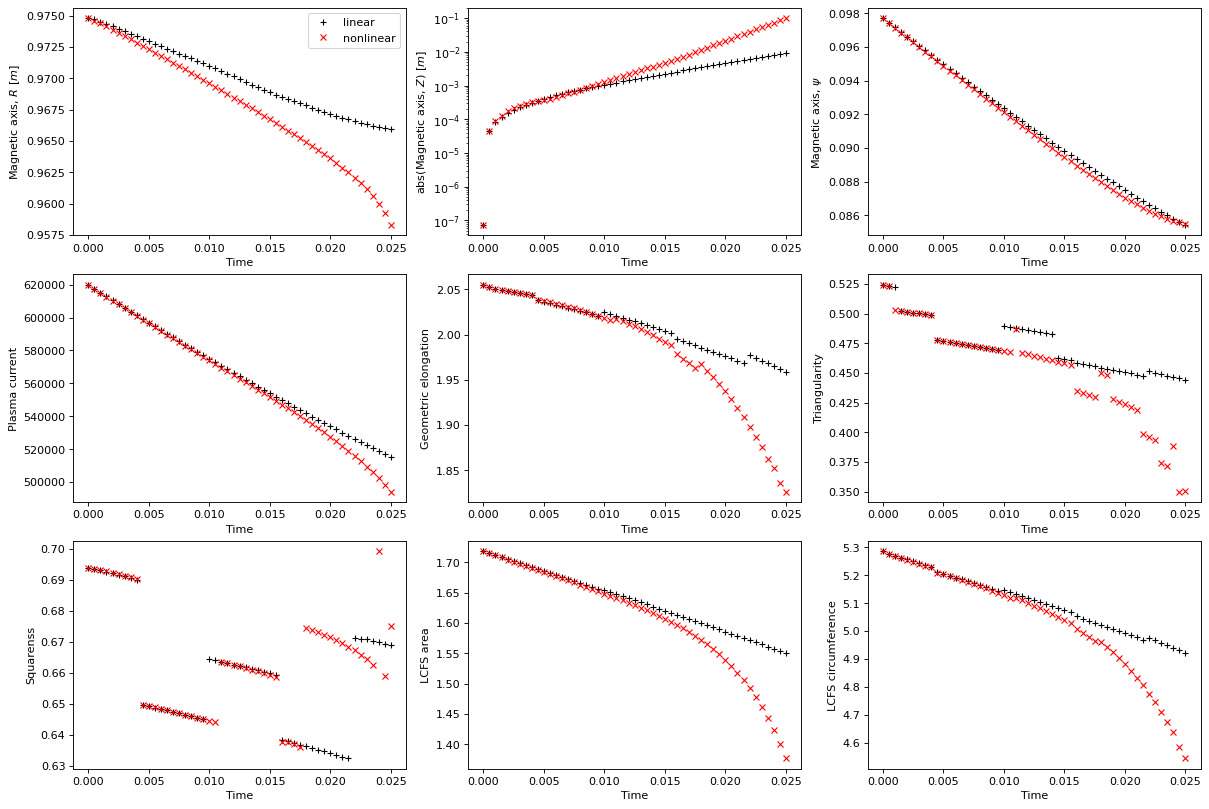

In [16]:
# Plot evolution of tracked values and compare between linear and non-linear evolution
fig, axs = plt.subplots(3, 3, figsize=(15, 10), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+', label='linear')
axs_flat[0].plot(history_times_nl, history_o_points_nl[:, 0],'rx', label='nonlinear')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('Magnetic axis, $R$ [$m$]')
axs_flat[0].legend()

axs_flat[1].plot(history_times, abs(history_o_points[:, 1]),'k+')
axs_flat[1].plot(history_times_nl, abs(history_o_points_nl[:, 1]),'rx')
axs_flat[1].set_yscale('log')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('abs(Magnetic axis, $Z$) [$m$]')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].plot(history_times_nl, history_o_points_nl[:, 2],'rx')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('Magnetic axis, $\psi$')

axs_flat[3].plot(history_times, history_currents[:,-1]*stepping.plasma_norm_factor,'k+')
axs_flat[3].plot(history_times_nl, history_currents_nl[:,-1]*stepping.plasma_norm_factor,'rx')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_elongation,'k+')
axs_flat[4].plot(history_times_nl, history_elongation_nl,'rx')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Geometric elongation')

axs_flat[5].plot(history_times, history_triangularity,'k+')
axs_flat[5].plot(history_times_nl, history_triangularity_nl,'rx')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Triangularity')

axs_flat[6].plot(history_times, history_squareness,'k+')
axs_flat[6].plot(history_times_nl, history_squareness_nl,'rx')
axs_flat[6].set_xlabel('Time')
axs_flat[6].set_ylabel('Squarenss')

axs_flat[7].plot(history_times, history_area,'k+')
axs_flat[7].plot(history_times_nl, history_area_nl,'rx')
axs_flat[7].set_xlabel('Time')
axs_flat[7].set_ylabel('LCFS area')

axs_flat[8].plot(history_times, history_length,'k+')
axs_flat[8].plot(history_times_nl, history_length_nl,'rx')
axs_flat[8].set_xlabel('Time')
axs_flat[8].set_ylabel('LCFS circumference')



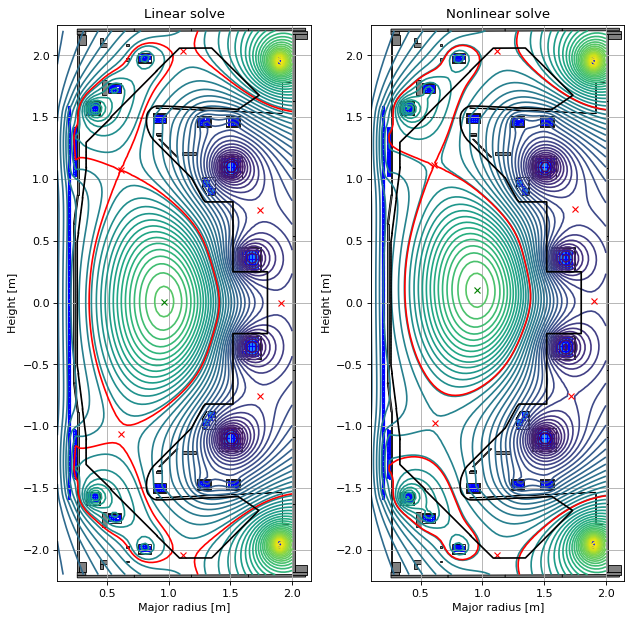

In [17]:
# plot the equilibria at the final time step
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)

ax1.grid(True, which='both')
history_equilibria[-1].plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title("Linear solve")

ax2.grid(True, which='both')
history_equilibria_nl[-1].plot(axis=ax2, show=False)
eq.tokamak.plot(axis=ax2, show=False)
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title("Nonlinear solve")

plt.tight_layout()


## Limited plasma example

Finally, we examine a limiter configuration (there is no fundamental difference from the process described above).

First we re-instantiate the equilibrium object.

In [18]:
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,
    Zmin=-2.2, Zmax=2.2,
    nx=65, 
    ny=129
)  

We load a set of coil currents that will give us a limiter plasma in our current tokamak.

In [6]:
import json
with open('limiter_currents.json', 'r') as f:
    current_values = json.load(f)

for key in current_values.keys():
    eq.tokamak.set_coil_current(key, current_values[key])

Now we set the profiles.

In [7]:
profiles = ConstrainPaxisIp(
    eq=eq,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

The final part of the setup is to do a forward solve and visualise the limiter equilibrium.
The red dashed line is the flux surface through the first X-point, however, the actual last closed flux surface in limiter equilibria is displayed as a full black line. 

In [ ]:
GSStaticSolver.solve(eq, profiles, target_relative_tolerance=1e-8, verbose=True)

fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

-----
Forward static solve starting...
Initial guess for plasma_psi successful, residual found.
Initial relative error = 1.02e+00
-----
Picard iteration: 0
Update too large, resized.
...relative error =  1.02e+00
-----
Picard iteration: 1
Update too large, resized.
...relative error =  9.56e-01
-----
Picard iteration: 2
Update too large, resized.
...relative error =  9.29e-01
-----
Picard iteration: 3
Update too large, resized.
...relative error =  8.98e-01
-----
Picard iteration: 4
Update too large, resized.
...relative error =  8.62e-01
-----
Picard iteration: 5
Update too large, resized.
...relative error =  8.19e-01
-----
Picard iteration: 6
Update too large, resized.
...relative error =  7.72e-01
-----
Picard iteration: 7
Update too large, resized.
...relative error =  7.18e-01
-----
Picard iteration: 8
Update too large, resized.
...relative error =  6.56e-01
-----
Picard iteration: 9
Update too large, resized.
...relative error =  5.85e-01
-----
Picard iteration: 10
Update too la

/Users/zn8047/Documents/freegs4e/freegs4e/jtor.py:550: RuntimeWarning: divide by zero encountered in scalar divide
  L = self.Ip / I_R - LBeta0 * (IR / I_R - 1)
/Users/zn8047/Documents/freegs4e/freegs4e/jtor.py:550: RuntimeWarning: invalid value encountered in scalar divide
  L = self.Ip / I_R - LBeta0 * (IR / I_R - 1)


Finally, we can do the nonlinear evolutive solve as before. First, we re-initialize the solver, which calculates the linearization of the dynamics relevant to this new equilibrium.

In [ ]:
from freegsnke import nonlinear_solve

stepping = nonlinear_solve.nl_solver(
    eq=eq, profiles=profiles, 
    full_timestep=.5e-3, 
    plasma_resistivity=1e-6, 
    GSStaticSolver=GSStaticSolver   
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 2.50e-09 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'threshold_dIy_dI', 'min_dIy_dI', and 'max_mode_frequency' option selected --> passive structure modes are selected according to these thresholds.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      4 selected with characteristic timescales larger than 'max_mode_frequency'
      29 selected that couple with the plasma more than 'threshold_dIy_dI', despite having fast timescales
      0 selected that couple with the plasma less than 'min_dIy_dI', despite having slow timescales
      total selected = 33 (out of 138)
   Total number of modes = 45 (12 active coils + 33 passive structures)
      (Note: some additional modes may be removed after Jacobian c

In [ ]:
# recalculate the active voltages using the new currents
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils] 

# number of time steps to simulate
max_count = 50

# reset the solver object by resetting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# initialising some variables for iteration and logging
counter = 0
t = 0

history_times_nl = [t]
history_currents_nl = [stepping.currents_vec]
history_equilibria_nl = [deepcopy(stepping.eq1)]
history_o_points_nl = [stepping.eq1.opt[0]]
history_elongation_nl = [stepping.eq1.geometricElongation()]
history_triangularity_nl = [stepping.eq1.triangularity()]
history_squareness_nl = [stepping.eq1.squareness()[1]]
history_area_nl = [stepping.eq1.separatrix_area()]
history_length_nl = [stepping.eq1.separatrix_length()]

# Simulate the forward evolution
while counter<max_count:

    print(f'Step: {counter}/{max_count-1}')
    print(f'--- t = {t:.2e}')
    
    # carry out the time step
    stepping.nlstepper(
        active_voltage_vec=U_active, 
        linear_only=False,
        target_relative_tol_currents=0.01,
        target_relative_tol_GS=0.01,

    )

    # store information on the time step
    t += stepping.dt_step
    history_times_nl.append(t)
    counter += 1
    
    # store time-advanced equilibrium, currents, and profiles (+ other quantites of interest)
    history_currents_nl.append(stepping.currents_vec)
    history_equilibria_nl.append(deepcopy(stepping.eq1))
    history_o_points_nl.append(stepping.eq1.opt[0])
    history_elongation_nl.append(stepping.eq1.geometricElongation())
    history_triangularity_nl.append(stepping.eq1.triangularity())
    history_squareness_nl.append(stepping.eq1.squareness()[1])
    history_area_nl.append(stepping.eq1.separatrix_area())
    history_length_nl.append(stepping.eq1.separatrix_length())

# transform lists to arrays
history_currents_nl = np.array(history_currents_nl)
history_times_nl = np.array(history_times_nl)
history_o_points_nl = np.array(history_o_points_nl)
history_elongation_nl = np.array(history_elongation_nl)
history_triangularity_nl = np.array(history_triangularity_nl)
history_squareness_nl = np.array(history_squareness_nl)
history_area_nl = np.array(history_area_nl)
history_length_nl = np.array(history_length_nl)

Step: 0/49
--- t = 0.00e+00
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 8.82e-03 (vs. requested 1.00e-02).
   Last max. relative flux change: 3.75e-03 (vs. requested 1.00e-02).
   Iterations taken: 3/50.
Step: 1/49
--- t = 5.00e-04
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 1.46e-03 (vs. requested 1.00e-02).
   Last max. relative flux change: 1.15e-03 (vs. requested 1.00e-02).
   Iterations taken: 3/50.
Step: 2/49
--- t = 1.00e-03
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 3.00e-03 (vs. requested 1.00e-02).
   Last max. relative flux change: 2.61e-03 (vs. requested 1.00e-02).
   Iterations taken: 2/50.
Step: 3/49
--- t = 1.50e-03
Forward evolutive solve SUCCESS.
   Last max. relative currents change: 3.04e-03 (vs. requested 1.00e-02).
   Last max. relative flux change: 3.81e-03 (vs. requested 1.00e-02).
   Iterations taken: 3/50.
Step: 4/49
--- t = 2.00e-03
Forward evolutive solve SUCCESS.
   Last max

Text(0, 0.5, 'LCFS circumference')

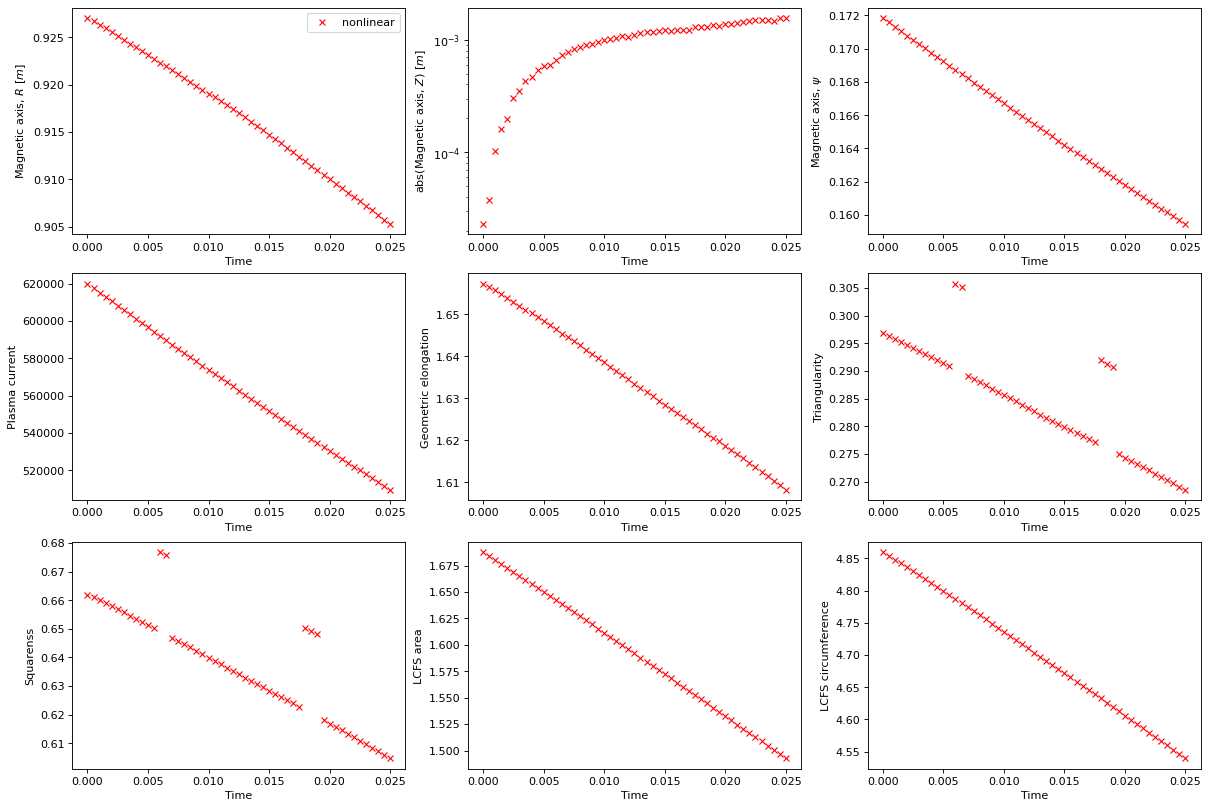

In [ ]:
# Plot evolution of tracked values and compare between linear and non-linear evolution
fig, axs = plt.subplots(3, 3, figsize=(15, 10), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times_nl, history_o_points_nl[:, 0],'rx', label='nonlinear')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('Magnetic axis, $R$ [$m$]')
axs_flat[0].legend()

axs_flat[1].plot(history_times_nl, abs(history_o_points_nl[:, 1]),'rx')
axs_flat[1].set_yscale('log')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('abs(Magnetic axis, $Z$) [$m$]')

axs_flat[2].plot(history_times_nl, history_o_points_nl[:, 2],'rx')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('Magnetic axis, $\psi$')

axs_flat[3].plot(history_times_nl, history_currents_nl[:,-1]*stepping.plasma_norm_factor,'rx')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times_nl, history_elongation_nl,'rx')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Geometric elongation')

axs_flat[5].plot(history_times_nl, history_triangularity_nl,'rx')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Triangularity')

axs_flat[6].plot(history_times_nl, history_squareness_nl,'rx')
axs_flat[6].set_xlabel('Time')
axs_flat[6].set_ylabel('Squarenss')

axs_flat[7].plot(history_times_nl, history_area_nl,'rx')
axs_flat[7].set_xlabel('Time')
axs_flat[7].set_ylabel('LCFS area')

axs_flat[8].plot(history_times_nl, history_length_nl,'rx')
axs_flat[8].set_xlabel('Time')
axs_flat[8].set_ylabel('LCFS circumference')



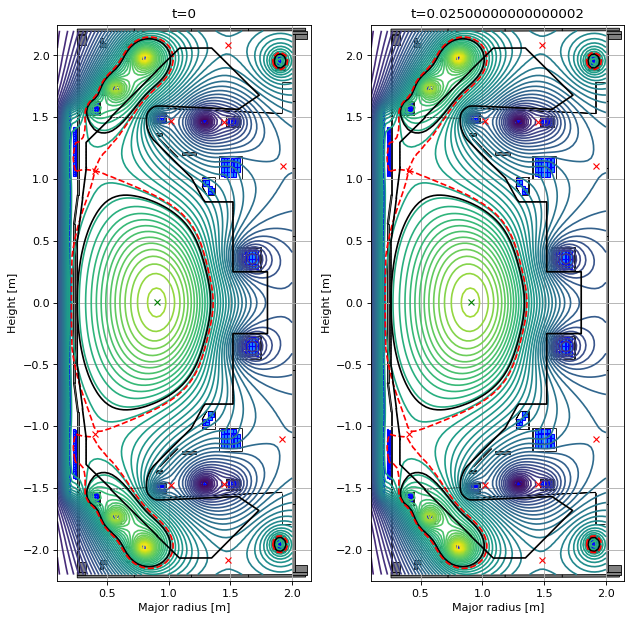

In [ ]:
# plot the equilibria at the final time step
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)

ax1.grid(True, which='both')
history_equilibria_nl[-1].plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title('t=0')

ax2.grid(True, which='both')
history_equilibria_nl[-1].plot(axis=ax2, show=False)
eq.tokamak.plot(axis=ax2, show=False)
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title('t='+str(t))
plt.tight_layout()